In [1]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
v0_data_dir = '../data/test_files_v0'
v12_data_dir = '../data/test_files_v12'


# Replace the path with your own. 
filenames_v0 = next(walk(v0_data_dir), (None, None, []))[2] 
filenames_v12 = next(walk(v12_data_dir), (None, None, []))[2] 


categories =  {}
for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
        categories[label] = 0
    categories[label] += 1 

# for file in filenames_v12:
#     label = (file.split("@")[1]).split('.')[0].strip().lower() 
#     if label not in categories.keys() : 
#         categories[label] = 0
#     categories[label] += 1   
    
print("\n==> All data : \n")
for x , y in categories.items() :
    print(x , y)




==> All data : 

test order dependency 103
randomness 17
time 42
network 31
platform dependency 2
resource leak 10
async wait 125
test case timeout 14
concurrency 48
unordered collections 51
floating point operations 3
too restrictive range 3
i_o 2


In [4]:
import random
from sklearn.model_selection import train_test_split

buggy_code = []
filenames = []
label_counts = {
    'async wait': 0,
    'unordered collections': 0,
    'concurrency': 0,
    'time': 0,
    'test order dependency': 0
}

selective_labels = ['time', 'concurrency']

for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower()
    if label in label_counts:
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
            label_counts[label] += 1

for file in filenames_v12:
    label = (file.split("@")[1]).split('.')[0].strip().lower()
    if label in selective_labels:
        with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
            label_counts[label] += 1

# Print the categories and their corresponding number before train-test split
print("------------before limiting--------------")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# Separate block for limiting the number of data points per category
max_data_points = {
    'async wait': 144,  # specify the number you want for each category
    'unordered collections': 144,
    'concurrency': 144,
    'time': 144,
    'test order dependency': 144
}

filtered_buggy_code = []
filtered_filenames = []
filtered_label_counts = {
    'async wait': 0,
    'unordered collections': 0,
    'concurrency': 0,
    'time': 0,
    'test order dependency': 0
}

# Shuffle the indices with a consistent seed
random.seed(42)
indices = list(range(len(buggy_code)))
random.shuffle(indices)

# Select data points while respecting the max_data_points limit
for i in indices:
    label = (filenames[i].split("@")[1]).split('.')[0].strip().lower()
    if label in filtered_label_counts and filtered_label_counts[label] < max_data_points[label]:
        filtered_buggy_code.append(buggy_code[i])
        filtered_filenames.append(filenames[i])
        filtered_label_counts[label] += 1

# Print the filtered categories and their corresponding number before train-test split
print("------------after limiting--------------")
for label, count in filtered_label_counts.items():
    print(f"{label}: {count}")

train_buggy_code, valid_buggy_code = train_test_split(filtered_buggy_code, test_size=0.2, random_state=42)
train_filenames, valid_filenames = train_test_split(filtered_filenames, test_size=0.2, random_state=42)


No data available for category async wait, skipping...
No data available for category unordered collections, skipping...
No data available for category test order dependency, skipping...
Training Data Breakdown:
concurrency: Total 38, Original 0, Augmented 38
time: Total 32, Original 0, Augmented 32

Testing Data Breakdown:
concurrency: Total 10, Original 0, Augmented 10
time: Total 8, Original 0, Augmented 8


In [5]:
label_to_int= {
    'async wait': 0,
    'unordered collections': 1,
    'concurrency': 2,
    'time': 3,
    'test order dependency': 4
}

In [6]:
from torch.utils.data import Dataset
import numpy as np
import random
m_len = 3402
class SiameseDataset(Dataset):
    def __init__(self, buggy_code, tokenizer, codebert, filenames, split):
        self.buggy_code = buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.filenames = filenames
        self.split = split
        self.max_len = 0
        
        # Preprocess filenames to map labels to indices
        self.label_to_indices = {}
        for index, filename in enumerate(filenames):
            label = self._extract_label(filename)
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(index)

        # For negative sampling
        self.labels = [self._extract_label(filename) for filename in filenames]
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self._extract_label(self.filenames[idx])

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])


            anchor = self._process_snippet(self.buggy_code[idx])
            positive = self._process_snippet(self.buggy_code[positive_idx])
            negative = self._process_snippet(self.buggy_code[negative_idx])
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False

            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'positive': torch.nn.functional.pad(positive, (0, m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, m_len - negative.size(0))),
                'label': anchor_label,  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split =='val':
            anchor_label = self._extract_label(self.filenames[idx])
            anchor = self._process_snippet(self.buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'label': anchor_label  # Optional, depends on how you want to use it
            }
        
    def _extract_label(self, filename):
        # Implement logic to extract label from filename
        return label_to_int[(filename.split("@")[1]).split('.')[0].strip().lower()]

    def _process_snippet(self, snippet):
        import torch

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:

            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:

            total_length = inputs['input_ids'].shape[1]
            # if total_length >= self.max_len:
            #     self.max_len = total_length
            #     print(self.max_len)
        
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

                # del input_segment, output_segment, cls_segment  # Free up memory
                # torch.cuda.empty_cache()  # Clear cache
                # gc.collect()  # Invoke garbage collector

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts


        
        # #CHECKING WHAT HAPPENS WHEN WE REMOVE MAX LENGTH CONSTRAINT
        # inputs = self.tokenizer(snippet, return_tensors='pt').to(device)
        # #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
        # print(inputs['input_ids'].shape[1])
        # if((inputs['input_ids'].shape[1])<512):
        #     with torch.no_grad():
        #         outs = self.codebert(**inputs)
        #     cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        #     return cls
        # else:
        #     print('longtest')
        #     i = 0
        #     part_vector =  []
        #     while ( i < (inputs['input_ids'].shape[1])-200) :
        #         print('in while')
        #         #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
        #         #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
        #         input_seg = [self.tokenizer.cls_token] + inputs['input_ids'][1][i:i+250] +[self.tokenizer.sep_token]
        #         with torch.no_grad():
        #             ots = self.codebert(**input_seg)
        #         cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
        #         #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
        #         #vector = cls[0].detach().numpy()
        #         parts.append(cls)
        #         i = i+100
        #     return parts
            
            

In [7]:

# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, tokenizer, model_codebert, train_filenames, 'train')
val_dataset = SiameseDataset(valid_buggy_code, tokenizer, model_codebert, valid_filenames, 'val')


# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [8]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [9]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])


  2%|▏         | 7/436 [00:00<00:24, 17.40it/s]

100%|██████████| 436/436 [00:16<00:00, 26.55it/s]


In [10]:

# Assuming plot_data is a list of 1D tensors of different lengths
max_length = max(tensor.size(0) for tensor in plot_data)
padded_data = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in plot_data]

In [11]:
max_length

3402

In [12]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid'] 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


In [13]:
# !python3 -m pip install matplotlib==3.5.2

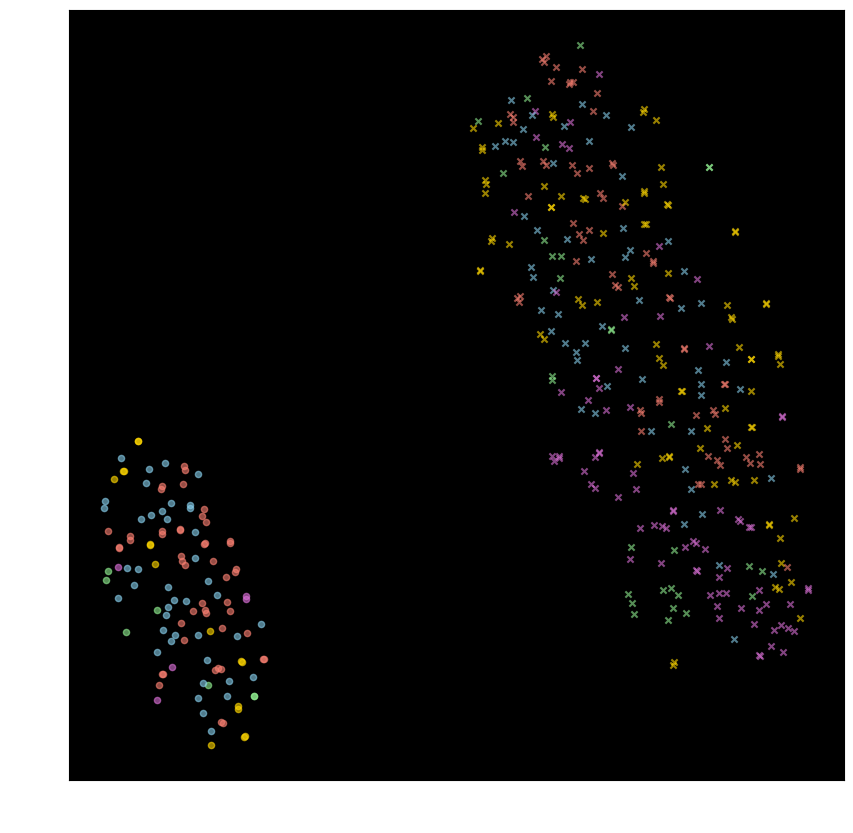

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
plt.gca().set_facecolor('black')
# Adjust the color of the ticks and labels for better visibility
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Component 1', color='white')
plt.ylabel('Component 2', color='white')

plt.show()


In [15]:
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import torch
# from sklearn.preprocessing import MinMaxScaler

# X = torch.stack(plot_data).cpu().numpy()
# labelsNums = plot_labels

# # Perform t-SNE dimensionality reduction
# X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# # Normalize the points
# scaler = MinMaxScaler()
# X_embedded_normalized = scaler.fit_transform(X_embedded)

# # Create the scatter plot
# plt.figure(figsize=(10, 10))
# for i in range(len(X_embedded_normalized)):
#     marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
#     plt.scatter(X_embedded_normalized[i, 0], X_embedded_normalized[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# # Set the background color to black
# plt.gca().set_facecolor('black')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')

# plt.show()


In [16]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [17]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [18]:
learning_rate = 1e-5
num_epochs = 200
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

In [19]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [20]:
from tqdm import tqdm
best_loss = 100.0
num_epochs = 350
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter('logs/flakyXbert_300_seed123456')
epoch_loss_list = []
for epoch in range(num_epochs):
    total_loss = 0.01
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()
        writer.add_scalar('Training Loss', loss.item(), epoch * len(train_dataloader) + i)
        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'flakyXbert_TimeConc_v2.pth')
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

2024-06-19 20:34:18.147327: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 20:34:18.162421: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 20:34:18.162439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 20:34:18.162452: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 20:34:18.166014: I tensorflow/core/platform/cpu_feature_g

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.58it/s]


Epoch 1/350, Loss: 1.1350725890939886


  2%|▏         | 1/55 [00:00<00:16,  3.23it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 2/350, Loss: 0.9638926561962474


100%|██████████| 55/55 [00:15<00:00,  3.47it/s]


Epoch 3/350, Loss: 0.9668378311504017


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 4/350, Loss: 0.9299962755333293


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 5/350, Loss: 0.9434536789330569


  2%|▏         | 1/55 [00:00<00:18,  2.91it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 6/350, Loss: 0.8949948171702298


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 7/350, Loss: 0.9075731891502034


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 8/350, Loss: 0.8901752988425168


100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoch 9/350, Loss: 0.8767941454974088


  2%|▏         | 1/55 [00:00<00:14,  3.76it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 10/350, Loss: 0.8313785598061301


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 11/350, Loss: 0.8387444617098028


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 12/350, Loss: 0.8092697394544428


  2%|▏         | 1/55 [00:00<00:19,  2.75it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Epoch 13/350, Loss: 0.8095877990505912


100%|██████████| 55/55 [00:16<00:00,  3.44it/s]


Epoch 14/350, Loss: 0.7345716174732555


100%|██████████| 55/55 [00:15<00:00,  3.45it/s]


Epoch 15/350, Loss: 0.7913417893756519


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 16/350, Loss: 0.693117523908615


100%|██████████| 55/55 [00:16<00:00,  3.39it/s]


Epoch 17/350, Loss: 0.7441640953150662


  2%|▏         | 1/55 [00:00<00:17,  3.16it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.44it/s]


Epoch 18/350, Loss: 0.7388793085488405


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 19/350, Loss: 0.6052532582499763


  2%|▏         | 1/55 [00:00<00:22,  2.40it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoch 20/350, Loss: 0.6694370314858176


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 21/350, Loss: 0.6200027207461271


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 22/350, Loss: 0.586641519351439


100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


Epoch 23/350, Loss: 0.5696000128009102


100%|██████████| 55/55 [00:15<00:00,  3.51it/s]


Epoch 24/350, Loss: 0.5624402813315391


100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Epoch 25/350, Loss: 0.5469681154977192


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 26/350, Loss: 0.5905158669135787


100%|██████████| 55/55 [00:15<00:00,  3.50it/s]


Epoch 27/350, Loss: 0.5225018679120323


100%|██████████| 55/55 [00:16<00:00,  3.26it/s]


Epoch 28/350, Loss: 0.4883867078586058


100%|██████████| 55/55 [00:16<00:00,  3.39it/s]


Epoch 29/350, Loss: 0.4960867558392611


  2%|▏         | 1/55 [00:00<00:14,  3.85it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoch 30/350, Loss: 0.4390848112756555


100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


Epoch 31/350, Loss: 0.5032390222332694


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 32/350, Loss: 0.43807243844053956


100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


Epoch 33/350, Loss: 0.4573465102477507


100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


Epoch 34/350, Loss: 0.44160499617186455


100%|██████████| 55/55 [00:16<00:00,  3.41it/s]


Epoch 35/350, Loss: 0.4310505954081362


100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Epoch 36/350, Loss: 0.44923367477005177


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 37/350, Loss: 0.46242512576688416


100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Epoch 38/350, Loss: 0.4403778164603493


100%|██████████| 55/55 [00:16<00:00,  3.35it/s]


Epoch 39/350, Loss: 0.4362099217122251


100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


Epoch 40/350, Loss: 0.40784646506742994


100%|██████████| 55/55 [00:16<00:00,  3.41it/s]


Epoch 41/350, Loss: 0.38023607585646885


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 42/350, Loss: 0.4230559404980052


100%|██████████| 55/55 [00:16<00:00,  3.39it/s]


Epoch 43/350, Loss: 0.4738367792259563


100%|██████████| 55/55 [00:15<00:00,  3.45it/s]


Epoch 44/350, Loss: 0.44431275106018236


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 45/350, Loss: 0.4030580936887047


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 46/350, Loss: 0.4370041068683971


  4%|▎         | 2/55 [00:00<00:09,  5.49it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 47/350, Loss: 0.401892844422297


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 48/350, Loss: 0.35317879417809567


100%|██████████| 55/55 [00:15<00:00,  3.54it/s]


Epoch 49/350, Loss: 0.4152478134469552


100%|██████████| 55/55 [00:15<00:00,  3.44it/s]


Epoch 50/350, Loss: 0.3391312474933537


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 51/350, Loss: 0.37894697694344953


100%|██████████| 55/55 [00:15<00:00,  3.56it/s]


Epoch 52/350, Loss: 0.33763525896180757


100%|██████████| 55/55 [00:16<00:00,  3.26it/s]


Epoch 53/350, Loss: 0.35627577958865597


100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


Epoch 54/350, Loss: 0.3758058725812218


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 55/350, Loss: 0.34372267726876515


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 56/350, Loss: 0.3360997982025146


100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


Epoch 57/350, Loss: 0.3822846735444935


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 58/350, Loss: 0.3509586644822901


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 59/350, Loss: 0.2984412823590365


100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


Epoch 60/350, Loss: 0.35894866386326874


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 61/350, Loss: 0.3173184788064523


100%|██████████| 55/55 [00:15<00:00,  3.61it/s]


Epoch 62/350, Loss: 0.3146710793105038


100%|██████████| 55/55 [00:16<00:00,  3.39it/s]


Epoch 63/350, Loss: 0.3249211624644019


100%|██████████| 55/55 [00:15<00:00,  3.47it/s]


Epoch 64/350, Loss: 0.3839346089525656


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 65/350, Loss: 0.326859206541018


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 66/350, Loss: 0.31776365614479235


100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


Epoch 67/350, Loss: 0.3092403237494555


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 68/350, Loss: 0.2855244733095169


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 69/350, Loss: 0.3391833239360289


100%|██████████| 55/55 [00:17<00:00,  3.14it/s]


Epoch 70/350, Loss: 0.3258178340142423


100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoch 71/350, Loss: 0.3200662495439702


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 72/350, Loss: 0.31807131418856704


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 73/350, Loss: 0.3146057809320363


100%|██████████| 55/55 [00:15<00:00,  3.53it/s]


Epoch 74/350, Loss: 0.32544217777252193


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 75/350, Loss: 0.2955529671203006


100%|██████████| 55/55 [00:17<00:00,  3.13it/s]


Epoch 76/350, Loss: 0.30296161625602025


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 77/350, Loss: 0.28840235150402244


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 78/350, Loss: 0.38967650739713144


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 79/350, Loss: 0.24369369125908072


100%|██████████| 55/55 [00:16<00:00,  3.33it/s]


Epoch 80/350, Loss: 0.27289953465895217


100%|██████████| 55/55 [00:16<00:00,  3.33it/s]


Epoch 81/350, Loss: 0.3090743265748024


100%|██████████| 55/55 [00:15<00:00,  3.46it/s]


Epoch 82/350, Loss: 0.3245990206274119


  2%|▏         | 1/55 [00:00<00:16,  3.22it/s]

Loss improved saving model


100%|██████████| 55/55 [00:18<00:00,  3.03it/s]


Epoch 83/350, Loss: 0.28232423599199813


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 84/350, Loss: 0.29268428781899536


100%|██████████| 55/55 [00:14<00:00,  3.67it/s]


Epoch 85/350, Loss: 0.27159963565522977


  2%|▏         | 1/55 [00:00<00:09,  5.41it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 86/350, Loss: 0.2408160119273446


100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


Epoch 87/350, Loss: 0.25455362489006733


100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


Epoch 88/350, Loss: 0.2742239216891202


100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


Epoch 89/350, Loss: 0.22488255098191173


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 90/350, Loss: 0.2811337921131741


100%|██████████| 55/55 [00:17<00:00,  3.12it/s]


Epoch 91/350, Loss: 0.2415191186124628


  2%|▏         | 1/55 [00:00<00:14,  3.80it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 92/350, Loss: 0.21397885345328937


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 93/350, Loss: 0.2384008658582514


100%|██████████| 55/55 [00:16<00:00,  3.24it/s]


Epoch 94/350, Loss: 0.23593969091502104


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 95/350, Loss: 0.191548942880197


  2%|▏         | 1/55 [00:00<00:10,  4.94it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 96/350, Loss: 0.23502051996642892


100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoch 97/350, Loss: 0.2646232782819054


100%|██████████| 55/55 [00:17<00:00,  3.11it/s]


Epoch 98/350, Loss: 0.24272907705198635


100%|██████████| 55/55 [00:17<00:00,  3.11it/s]


Epoch 99/350, Loss: 0.3061332199085842


100%|██████████| 55/55 [00:15<00:00,  3.44it/s]


Epoch 100/350, Loss: 0.2368206107182936


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 101/350, Loss: 0.23647329404679213


100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


Epoch 102/350, Loss: 0.2510631171519106


100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoch 103/350, Loss: 0.21038274199854243


100%|██████████| 55/55 [00:16<00:00,  3.24it/s]


Epoch 104/350, Loss: 0.268983606625687


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 105/350, Loss: 0.2004745891527696


100%|██████████| 55/55 [00:15<00:00,  3.45it/s]


Epoch 106/350, Loss: 0.2224873788356781


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 107/350, Loss: 0.2334777356928045


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 108/350, Loss: 0.289629853757945


100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Epoch 109/350, Loss: 0.2814201982563192


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 110/350, Loss: 0.2170141709501093


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 111/350, Loss: 0.20081137043237685


  2%|▏         | 1/55 [00:00<00:19,  2.81it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 112/350, Loss: 0.2516586183526299


  2%|▏         | 1/55 [00:00<00:14,  3.62it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 113/350, Loss: 0.20179285316033796


  2%|▏         | 1/55 [00:00<00:15,  3.50it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 114/350, Loss: 0.20560671934756367


100%|██████████| 55/55 [00:17<00:00,  3.15it/s]


Epoch 115/350, Loss: 0.22331174209443005


100%|██████████| 55/55 [00:16<00:00,  3.39it/s]


Epoch 116/350, Loss: 0.21010508202422748


100%|██████████| 55/55 [00:16<00:00,  3.26it/s]


Epoch 117/350, Loss: 0.164657284357331


100%|██████████| 55/55 [00:16<00:00,  3.35it/s]


Epoch 118/350, Loss: 0.18866517385027626


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 119/350, Loss: 0.21237562668323517


100%|██████████| 55/55 [00:15<00:00,  3.45it/s]


Epoch 120/350, Loss: 0.16100771105831319


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 121/350, Loss: 0.2104977464513345


100%|██████████| 55/55 [00:15<00:00,  3.44it/s]


Epoch 122/350, Loss: 0.2095920357216488


  2%|▏         | 1/55 [00:00<00:18,  2.94it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:15,  3.42it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.41it/s]


Epoch 123/350, Loss: 0.1425153507807038


100%|██████████| 55/55 [00:17<00:00,  3.12it/s]


Epoch 124/350, Loss: 0.17288287922469053


100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


Epoch 125/350, Loss: 0.1838185718493028


100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Epoch 126/350, Loss: 0.16879851198738272


100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoch 127/350, Loss: 0.16090773862600327


100%|██████████| 55/55 [00:16<00:00,  3.41it/s]


Epoch 128/350, Loss: 0.17918042476610704


  2%|▏         | 1/55 [00:00<00:23,  2.30it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 129/350, Loss: 0.14369218759645114


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


Epoch 130/350, Loss: 0.23896767433123153


100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoch 131/350, Loss: 0.20531850637089122


100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoch 132/350, Loss: 0.19897898276827553


100%|██████████| 55/55 [00:15<00:00,  3.58it/s]


Epoch 133/350, Loss: 0.22537985881350256


  2%|▏         | 1/55 [00:00<00:19,  2.76it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:15,  3.31it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 134/350, Loss: 0.1395999453663826


100%|██████████| 55/55 [00:16<00:00,  3.39it/s]


Epoch 135/350, Loss: 0.15067714050141248


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 136/350, Loss: 0.17477007633989508


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 137/350, Loss: 0.15099464970285242


100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


Epoch 138/350, Loss: 0.16629023271257226


100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


Epoch 139/350, Loss: 0.15801879821582274


100%|██████████| 55/55 [00:16<00:00,  3.24it/s]


Epoch 140/350, Loss: 0.1559010900259018


  2%|▏         | 1/55 [00:00<00:27,  1.94it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.39it/s]


Epoch 141/350, Loss: 0.14601456567374144


100%|██████████| 55/55 [00:15<00:00,  3.51it/s]


Epoch 142/350, Loss: 0.10002492629398


100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


Epoch 143/350, Loss: 0.15481300113959745


  2%|▏         | 1/55 [00:00<00:22,  2.39it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 144/350, Loss: 0.1547921889586882


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 145/350, Loss: 0.13240285004810853


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 146/350, Loss: 0.13207142654874107


100%|██████████| 55/55 [00:16<00:00,  3.33it/s]


Epoch 147/350, Loss: 0.1718583008484407


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 148/350, Loss: 0.13286575773629275


100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


Epoch 149/350, Loss: 0.12585868554765528


100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


Epoch 150/350, Loss: 0.17060460858453402


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 151/350, Loss: 0.20918160951679401


100%|██████████| 55/55 [00:17<00:00,  3.15it/s]


Epoch 152/350, Loss: 0.15040984320098702


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 153/350, Loss: 0.1313742913007736


100%|██████████| 55/55 [00:15<00:00,  3.51it/s]


Epoch 154/350, Loss: 0.12427327528324994


  4%|▎         | 2/55 [00:00<00:10,  4.97it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 155/350, Loss: 0.14856954356215216


100%|██████████| 55/55 [00:17<00:00,  3.14it/s]


Epoch 156/350, Loss: 0.14314907671104776


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 157/350, Loss: 0.11477311839840629


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 158/350, Loss: 0.10408007614720952


100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


Epoch 159/350, Loss: 0.16945954632759094


100%|██████████| 55/55 [00:16<00:00,  3.26it/s]


Epoch 160/350, Loss: 0.13274111494151028


100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


Epoch 161/350, Loss: 0.16359987167878584


100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


Epoch 162/350, Loss: 0.1542139607776295


100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoch 163/350, Loss: 0.21306951049783013


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 164/350, Loss: 0.1036262092644518


100%|██████████| 55/55 [00:16<00:00,  3.24it/s]


Epoch 165/350, Loss: 0.1473514188798991


  2%|▏         | 1/55 [00:00<00:20,  2.58it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.47it/s]


Epoch 166/350, Loss: 0.14329402369260788


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 167/350, Loss: 0.12442737564173612


  2%|▏         | 1/55 [00:00<00:15,  3.51it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.33it/s]


Epoch 168/350, Loss: 0.2011399564797228


100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch 169/350, Loss: 0.13532583581859414


100%|██████████| 55/55 [00:16<00:00,  3.33it/s]


Epoch 170/350, Loss: 0.13305194395238704


100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


Epoch 171/350, Loss: 0.14409916160865263


  2%|▏         | 1/55 [00:00<00:25,  2.12it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Epoch 172/350, Loss: 0.14448330189423128


100%|██████████| 55/55 [00:16<00:00,  3.24it/s]


Epoch 173/350, Loss: 0.1139464008916508


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 174/350, Loss: 0.15338051851229234


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 175/350, Loss: 0.14265441559661518


100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Epoch 176/350, Loss: 0.0961957246444442


100%|██████████| 55/55 [00:16<00:00,  3.41it/s]


Epoch 177/350, Loss: 0.08570389236645265


100%|██████████| 55/55 [00:15<00:00,  3.44it/s]


Epoch 178/350, Loss: 0.14613595283573325


100%|██████████| 55/55 [00:15<00:00,  3.45it/s]


Epoch 179/350, Loss: 0.10015709729086268


100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Epoch 180/350, Loss: 0.23225700859048148


100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


Epoch 181/350, Loss: 0.10504826405915346


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 182/350, Loss: 0.10323372338034889


100%|██████████| 55/55 [00:16<00:00,  3.26it/s]


Epoch 183/350, Loss: 0.10418249494379217


100%|██████████| 55/55 [00:16<00:00,  3.33it/s]


Epoch 184/350, Loss: 0.09572400048104199


  2%|▏         | 1/55 [00:00<00:14,  3.80it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:19,  2.70it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.11it/s]


Epoch 185/350, Loss: 0.11224402951652353


  2%|▏         | 1/55 [00:00<00:15,  3.40it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:13,  3.85it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:17,  2.92it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:17,  2.93it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 186/350, Loss: 0.11982415417107668


100%|██████████| 55/55 [00:16<00:00,  3.24it/s]


Epoch 187/350, Loss: 0.09226232296770269


100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoch 188/350, Loss: 0.09474735182523727


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 189/350, Loss: 0.12384002578258514


  2%|▏         | 1/55 [00:00<00:20,  2.64it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 190/350, Loss: 0.10540556572784077


  2%|▏         | 1/55 [00:00<00:15,  3.57it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 191/350, Loss: 0.08897497590021654


100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


Epoch 192/350, Loss: 0.1242898841175166


100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch 193/350, Loss: 0.10191485587575219


  2%|▏         | 1/55 [00:00<00:16,  3.20it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 194/350, Loss: 0.11540030190619555


100%|██████████| 55/55 [00:16<00:00,  3.41it/s]


Epoch 195/350, Loss: 0.08394305791096253


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 196/350, Loss: 0.08657052466544238


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:19,  2.70it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:17,  2.96it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 197/350, Loss: 0.1586325523907488


  2%|▏         | 1/55 [00:00<00:17,  3.05it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Epoch 198/350, Loss: 0.069059593742544


100%|██████████| 55/55 [00:15<00:00,  3.57it/s]


Epoch 199/350, Loss: 0.08904367729750547


  2%|▏         | 1/55 [00:00<00:15,  3.54it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 200/350, Loss: 0.13448677771199832


100%|██████████| 55/55 [00:16<00:00,  3.35it/s]


Epoch 201/350, Loss: 0.11121193174340507


100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Epoch 202/350, Loss: 0.09330214184522628


  2%|▏         | 1/55 [00:00<00:24,  2.22it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.13it/s]


Epoch 203/350, Loss: 0.11616285460645502


100%|██████████| 55/55 [00:15<00:00,  3.54it/s]


Epoch 204/350, Loss: 0.09648073590343649


100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Epoch 205/350, Loss: 0.06064983732050115


  2%|▏         | 1/55 [00:00<00:18,  2.99it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:18,  2.80it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


Epoch 206/350, Loss: 0.11813403033126484


100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


Epoch 207/350, Loss: 0.07578185380588878


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 208/350, Loss: 0.10895117335427891


  2%|▏         | 1/55 [00:00<00:16,  3.25it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.08it/s]


Epoch 209/350, Loss: 0.10066397925398567


  2%|▏         | 1/55 [00:00<00:21,  2.52it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:17,  3.03it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:18,  2.84it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.35it/s]


Epoch 210/350, Loss: 0.08369070065021514


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 211/350, Loss: 0.0781323700167916


100%|██████████| 55/55 [00:15<00:00,  3.45it/s]


Epoch 212/350, Loss: 0.08908674097603017


  2%|▏         | 1/55 [00:00<00:28,  1.86it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:18,  2.87it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 213/350, Loss: 0.07256494439190084


  2%|▏         | 1/55 [00:00<00:17,  3.07it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:19,  2.75it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:19,  2.65it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:18,  2.75it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:01<00:17,  2.91it/s]

Loss improved saving model


 11%|█         | 6/55 [00:01<00:14,  3.29it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 214/350, Loss: 0.06687722033804112


100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoch 215/350, Loss: 0.07524813850901343


100%|██████████| 55/55 [00:15<00:00,  3.46it/s]


Epoch 216/350, Loss: 0.08108139543099836


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 217/350, Loss: 0.08939103379574688


  2%|▏         | 1/55 [00:00<00:17,  3.07it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 218/350, Loss: 0.08099081262675198


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 219/350, Loss: 0.09542099485072222


  2%|▏         | 1/55 [00:00<00:16,  3.24it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 220/350, Loss: 0.0679349944374778


100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


Epoch 221/350, Loss: 0.07076652649857781


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 222/350, Loss: 0.060020182387395336


100%|██████████| 55/55 [00:15<00:00,  3.47it/s]


Epoch 223/350, Loss: 0.0937466927929358


100%|██████████| 55/55 [00:15<00:00,  3.50it/s]


Epoch 224/350, Loss: 0.07504649274457584


  2%|▏         | 1/55 [00:00<00:13,  3.97it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:26,  1.98it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:20,  2.56it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 225/350, Loss: 0.10815679136731407


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 226/350, Loss: 0.03824264180660247


100%|██████████| 55/55 [00:15<00:00,  3.44it/s]


Epoch 227/350, Loss: 0.07305589918114921


  2%|▏         | 1/55 [00:00<00:19,  2.83it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:17,  3.09it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:16,  3.13it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 228/350, Loss: 0.0415423163338141


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 229/350, Loss: 0.0494661323428154


  2%|▏         | 1/55 [00:00<00:22,  2.45it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:17,  3.02it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.24it/s]


Epoch 230/350, Loss: 0.09104504616152156


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 231/350, Loss: 0.044861388108947055


100%|██████████| 55/55 [00:16<00:00,  3.38it/s]


Epoch 232/350, Loss: 0.07470562949505719


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:17,  3.01it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.08it/s]


Epoch 233/350, Loss: 0.08507834812185981


  2%|▏         | 1/55 [00:00<00:18,  2.90it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:14,  3.61it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.24it/s]


Epoch 234/350, Loss: 0.06067160222747109


  2%|▏         | 1/55 [00:00<00:17,  3.15it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:17,  3.02it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 235/350, Loss: 0.08726016828688708


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 236/350, Loss: 0.0764200178438967


100%|██████████| 55/55 [00:15<00:00,  3.54it/s]


Epoch 237/350, Loss: 0.08298697610876776


  2%|▏         | 1/55 [00:00<00:25,  2.15it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.55it/s]


Epoch 238/350, Loss: 0.07266286236047745


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 239/350, Loss: 0.07569510954076593


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 240/350, Loss: 0.055786774548617274


  2%|▏         | 1/55 [00:00<00:15,  3.54it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


Epoch 241/350, Loss: 0.04175363728674975


  2%|▏         | 1/55 [00:00<00:15,  3.55it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:20,  2.59it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 242/350, Loss: 0.08851147297837517


100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoch 243/350, Loss: 0.08795335892655633


100%|██████████| 55/55 [00:15<00:00,  3.56it/s]


Epoch 244/350, Loss: 0.04523545006188479


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 245/350, Loss: 0.09517030570723793


  4%|▎         | 2/55 [00:00<00:14,  3.75it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.54it/s]


Epoch 246/350, Loss: 0.0657028606371446


100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


Epoch 247/350, Loss: 0.055503540049899706


  2%|▏         | 1/55 [00:00<00:24,  2.21it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:17,  3.11it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:14,  3.53it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:15,  3.33it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:01<00:15,  3.30it/s]

Loss improved saving model


 11%|█         | 6/55 [00:01<00:14,  3.33it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.41it/s]


Epoch 248/350, Loss: 0.0819341528524052


100%|██████████| 55/55 [00:16<00:00,  3.33it/s]


Epoch 249/350, Loss: 0.057621097196232186


  2%|▏         | 1/55 [00:00<00:13,  4.08it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:18,  2.91it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:16,  3.18it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 250/350, Loss: 0.053624462306499476


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 251/350, Loss: 0.04469101324406537


  2%|▏         | 1/55 [00:00<00:16,  3.24it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:17,  3.05it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:18,  2.81it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoch 252/350, Loss: 0.040972480215809556


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 253/350, Loss: 0.06535454287854107


  2%|▏         | 1/55 [00:00<00:28,  1.87it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:19,  2.68it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:24,  2.11it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.07it/s]


Epoch 254/350, Loss: 0.056918975342403755


100%|██████████| 55/55 [00:16<00:00,  3.41it/s]


Epoch 255/350, Loss: 0.0957238854711706


  2%|▏         | 1/55 [00:00<00:25,  2.11it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


Epoch 256/350, Loss: 0.0484431172338399


  2%|▏         | 1/55 [00:00<00:18,  2.87it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 257/350, Loss: 0.03178007850321857


  2%|▏         | 1/55 [00:00<00:10,  5.04it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:10,  4.83it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 258/350, Loss: 0.07080290361967953


  2%|▏         | 1/55 [00:00<00:16,  3.37it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:20,  2.59it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:18,  2.82it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:17,  2.84it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.08it/s]


Epoch 259/350, Loss: 0.0320560997561975


  2%|▏         | 1/55 [00:00<00:17,  3.01it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:15,  3.37it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:16,  3.12it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.50it/s]


Epoch 260/350, Loss: 0.0270973857532848


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 261/350, Loss: 0.05002798049016432


  2%|▏         | 1/55 [00:00<00:22,  2.43it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 262/350, Loss: 0.049449944263154806


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 263/350, Loss: 0.03789791427959095


  2%|▏         | 1/55 [00:00<00:18,  2.91it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:15,  3.32it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.26it/s]


Epoch 264/350, Loss: 0.03320871229605241


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:19,  2.74it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:15,  3.30it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


Epoch 265/350, Loss: 0.03190406659516421


  2%|▏         | 1/55 [00:00<00:22,  2.42it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:20,  2.55it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:17,  3.04it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoch 266/350, Loss: 0.049729721827940505


  2%|▏         | 1/55 [00:00<00:33,  1.61it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:01<00:28,  1.85it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


Epoch 267/350, Loss: 0.12025890625065024


100%|██████████| 55/55 [00:16<00:00,  3.26it/s]


Epoch 268/350, Loss: 0.06703854356028817


  2%|▏         | 1/55 [00:00<00:16,  3.26it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:19,  2.70it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 269/350, Loss: 0.07914356593110344


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.12it/s]


Epoch 270/350, Loss: 0.06558785523609681


100%|██████████| 55/55 [00:16<00:00,  3.29it/s]


Epoch 271/350, Loss: 0.03946936987746845


  2%|▏         | 1/55 [00:00<00:21,  2.48it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:16,  3.18it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:16,  3.11it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:20,  2.47it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 272/350, Loss: 0.04434988353469155


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 273/350, Loss: 0.043151139031757005


100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Epoch 274/350, Loss: 0.05287221646850759


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 275/350, Loss: 0.041737160666422406


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


Epoch 276/350, Loss: 0.05500050963055003


  2%|▏         | 1/55 [00:00<00:20,  2.63it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Epoch 277/350, Loss: 0.043321296204220164


  2%|▏         | 1/55 [00:00<00:18,  2.86it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.33it/s]


Epoch 278/350, Loss: 0.027372105863961306


100%|██████████| 55/55 [00:15<00:00,  3.61it/s]


Epoch 279/350, Loss: 0.03188306842067025


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:12,  4.19it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:13,  3.89it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:15,  3.32it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:01<00:14,  3.34it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Epoch 280/350, Loss: 0.0356654687740586


  2%|▏         | 1/55 [00:00<00:19,  2.71it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:19,  2.72it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Epoch 281/350, Loss: 0.034616875144568356


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 282/350, Loss: 0.03952621306614442


  2%|▏         | 1/55 [00:00<00:17,  3.17it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:15,  3.41it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:14,  3.50it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.55it/s]


Epoch 283/350, Loss: 0.06273915893381292


100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


Epoch 284/350, Loss: 0.048193485260009765


100%|██████████| 55/55 [00:16<00:00,  3.39it/s]


Epoch 285/350, Loss: 0.06759345616535707


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 286/350, Loss: 0.12581003014066003


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:22,  2.36it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


Epoch 287/350, Loss: 0.031981361763043836


  2%|▏         | 1/55 [00:00<00:20,  2.66it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:20,  2.60it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.26it/s]


Epoch 288/350, Loss: 0.02428282557292418


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 289/350, Loss: 0.04236706173961812


  2%|▏         | 1/55 [00:00<00:21,  2.53it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


Epoch 290/350, Loss: 0.0711067014499144


  2%|▏         | 1/55 [00:00<00:21,  2.53it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


Epoch 291/350, Loss: 0.17004217292503876


  2%|▏         | 1/55 [00:00<00:21,  2.54it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:20,  2.59it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 292/350, Loss: 0.051634622335433956


  2%|▏         | 1/55 [00:00<00:21,  2.52it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 293/350, Loss: 0.08365342851118608


100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


Epoch 294/350, Loss: 0.08247894702716307


  2%|▏         | 1/55 [00:00<00:15,  3.45it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 295/350, Loss: 0.03366072276505557


  2%|▏         | 1/55 [00:00<00:19,  2.83it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:20,  2.53it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:20,  2.55it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:20,  2.47it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:01<00:17,  2.88it/s]

Loss improved saving model


 11%|█         | 6/55 [00:02<00:18,  2.66it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


Epoch 296/350, Loss: 0.02644631974805485


  2%|▏         | 1/55 [00:00<00:20,  2.67it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:16,  3.22it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:15,  3.41it/s]

Loss improved saving model
Loss improved saving model


  9%|▉         | 5/55 [00:01<00:15,  3.22it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


Epoch 297/350, Loss: 0.023686182130466808


  2%|▏         | 1/55 [00:00<00:21,  2.54it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:16,  3.25it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 298/350, Loss: 0.028087752282619477


  2%|▏         | 1/55 [00:00<00:13,  4.03it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:16,  3.13it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:16,  3.19it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:14,  3.52it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


Epoch 299/350, Loss: 0.02255071473121643


  2%|▏         | 1/55 [00:00<00:25,  2.08it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


Epoch 300/350, Loss: 0.023229278526522897


  2%|▏         | 1/55 [00:00<00:15,  3.42it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:24,  2.13it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:22,  2.27it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:19,  2.65it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:01<00:18,  2.76it/s]

Loss improved saving model


 11%|█         | 6/55 [00:02<00:17,  2.76it/s]

Loss improved saving model


 13%|█▎        | 7/55 [00:02<00:18,  2.56it/s]

Loss improved saving model


 15%|█▍        | 8/55 [00:02<00:16,  2.83it/s]

Loss improved saving model


 16%|█▋        | 9/55 [00:03<00:17,  2.65it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 301/350, Loss: 0.01713455390930176


  2%|▏         | 1/55 [00:00<00:17,  3.02it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:14,  3.54it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:20,  2.58it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:23,  2.17it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:02<00:22,  2.25it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 302/350, Loss: 0.027462121069431304


  2%|▏         | 1/55 [00:00<00:21,  2.53it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:16,  3.16it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:16,  3.23it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.44it/s]


Epoch 303/350, Loss: 0.021931216700510545


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 304/350, Loss: 0.04560593654892661


100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Epoch 305/350, Loss: 0.07571967803348194


  2%|▏         | 1/55 [00:00<00:18,  2.99it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:20,  2.57it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 306/350, Loss: 0.03226428130539981


  2%|▏         | 1/55 [00:00<00:20,  2.63it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:18,  2.84it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:22,  2.35it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:17,  2.87it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


Epoch 307/350, Loss: 0.04198209132389588


  2%|▏         | 1/55 [00:00<00:28,  1.92it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.62it/s]


Epoch 308/350, Loss: 0.02867815538969907


  2%|▏         | 1/55 [00:00<00:25,  2.12it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:21,  2.52it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:19,  2.63it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.14it/s]


Epoch 309/350, Loss: 0.04300769517096606


  2%|▏         | 1/55 [00:00<00:15,  3.57it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.46it/s]


Epoch 310/350, Loss: 0.04266640588370236


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 311/350, Loss: 0.06142453636364503


100%|██████████| 55/55 [00:15<00:00,  3.53it/s]


Epoch 312/350, Loss: 0.02384700060974468


  2%|▏         | 1/55 [00:00<00:19,  2.79it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:17,  2.95it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:18,  2.83it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 313/350, Loss: 0.0365232049443505


100%|██████████| 55/55 [00:16<00:00,  3.27it/s]


Epoch 314/350, Loss: 0.03246604790470817


  2%|▏         | 1/55 [00:00<00:15,  3.44it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:15,  3.48it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:15,  3.45it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:17,  2.88it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:01<00:15,  3.13it/s]

Loss improved saving model


 11%|█         | 6/55 [00:01<00:14,  3.37it/s]

Loss improved saving model


 13%|█▎        | 7/55 [00:02<00:14,  3.32it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 315/350, Loss: 0.021715999093922703


100%|██████████| 55/55 [00:15<00:00,  3.57it/s]


Epoch 316/350, Loss: 0.03666425703330473


  2%|▏         | 1/55 [00:00<00:17,  3.03it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:16,  3.29it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 317/350, Loss: 0.047334988588636565


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:16,  3.16it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:17,  2.95it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:16,  3.04it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:01<00:16,  2.94it/s]

Loss improved saving model


 11%|█         | 6/55 [00:01<00:16,  3.01it/s]

Loss improved saving model


 13%|█▎        | 7/55 [00:02<00:16,  2.94it/s]

Loss improved saving model


 15%|█▍        | 8/55 [00:02<00:18,  2.59it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


Epoch 318/350, Loss: 0.029031720118089157


  2%|▏         | 1/55 [00:00<00:14,  3.67it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:14,  3.74it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.32it/s]


Epoch 319/350, Loss: 0.03907933564077724


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 320/350, Loss: 0.03802140128612518


  2%|▏         | 1/55 [00:00<00:19,  2.70it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 321/350, Loss: 0.0356772989413955


100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


Epoch 322/350, Loss: 0.04567683234539899


100%|██████████| 55/55 [00:15<00:00,  3.52it/s]


Epoch 323/350, Loss: 0.029866780107671565


100%|██████████| 55/55 [00:15<00:00,  3.44it/s]


Epoch 324/350, Loss: 0.02429675842957063


100%|██████████| 55/55 [00:15<00:00,  3.63it/s]


Epoch 325/350, Loss: 0.047521589192477134


  2%|▏         | 1/55 [00:00<00:19,  2.80it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:14,  3.66it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.35it/s]


Epoch 326/350, Loss: 0.042273581743240356


  2%|▏         | 1/55 [00:00<00:17,  3.16it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:15,  3.41it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 327/350, Loss: 0.04631789154356176


  2%|▏         | 1/55 [00:00<00:20,  2.62it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:17,  3.11it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 328/350, Loss: 0.02045150877128948


  2%|▏         | 1/55 [00:00<00:30,  1.76it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:21,  2.47it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


Epoch 329/350, Loss: 0.04065448794581673


  2%|▏         | 1/55 [00:00<00:24,  2.24it/s]

Loss improved saving model


100%|██████████| 55/55 [00:18<00:00,  3.03it/s]


Epoch 330/350, Loss: 0.07690321522409266


  2%|▏         | 1/55 [00:00<00:22,  2.45it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:15,  3.46it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.53it/s]


Epoch 331/350, Loss: 0.03806175254691731


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:11,  4.59it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:12,  4.24it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 332/350, Loss: 0.0424511867869984


  2%|▏         | 1/55 [00:00<00:16,  3.27it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:18,  2.90it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:16,  3.25it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:16,  3.02it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:01<00:21,  2.35it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


Epoch 333/350, Loss: 0.02852451046488502


  2%|▏         | 1/55 [00:00<00:15,  3.49it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 334/350, Loss: 0.026223072176629846


  2%|▏         | 1/55 [00:00<00:14,  3.67it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:14,  3.77it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:13,  3.81it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 335/350, Loss: 0.01652542315829884


100%|██████████| 55/55 [00:16<00:00,  3.40it/s]


Epoch 336/350, Loss: 0.02863231535391374


  2%|▏         | 1/55 [00:00<00:30,  1.75it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.13it/s]


Epoch 337/350, Loss: 0.057834636254744096


  2%|▏         | 1/55 [00:00<00:19,  2.71it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:18,  2.93it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:16,  3.15it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


Epoch 338/350, Loss: 0.01800285595113581


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


  2%|▏         | 1/55 [00:00<00:12,  4.19it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


Epoch 339/350, Loss: 0.03675461347536607


  2%|▏         | 1/55 [00:00<00:23,  2.31it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:25,  2.05it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


Epoch 340/350, Loss: 0.05402491624788804


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 341/350, Loss: 0.05878361873735081


  2%|▏         | 1/55 [00:00<00:21,  2.46it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:22,  2.32it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.35it/s]


Epoch 342/350, Loss: 0.06202355572852221


  2%|▏         | 1/55 [00:00<00:17,  3.10it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:21,  2.46it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:22,  2.31it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:18,  2.71it/s]

Loss improved saving model


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 343/350, Loss: 0.029598098489371213


100%|██████████| 55/55 [00:16<00:00,  3.34it/s]


Epoch 344/350, Loss: 0.04341763925552368


  2%|▏         | 1/55 [00:00<00:16,  3.19it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:19,  2.76it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:01<00:19,  2.67it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:15,  3.30it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


Epoch 345/350, Loss: 0.033224335757168856


  0%|          | 0/55 [00:00<?, ?it/s]

Loss improved saving model


  4%|▎         | 2/55 [00:00<00:14,  3.61it/s]

Loss improved saving model


  5%|▌         | 3/55 [00:00<00:18,  2.81it/s]

Loss improved saving model


  7%|▋         | 4/55 [00:01<00:21,  2.42it/s]

Loss improved saving model


  9%|▉         | 5/55 [00:01<00:19,  2.56it/s]

Loss improved saving model


 11%|█         | 6/55 [00:02<00:21,  2.31it/s]

Loss improved saving model


 13%|█▎        | 7/55 [00:02<00:18,  2.60it/s]

Loss improved saving model


 15%|█▍        | 8/55 [00:02<00:15,  2.95it/s]

Loss improved saving model


 16%|█▋        | 9/55 [00:03<00:18,  2.46it/s]

Loss improved saving model


 18%|█▊        | 10/55 [00:03<00:16,  2.76it/s]

Loss improved saving model


 20%|██        | 11/55 [00:04<00:16,  2.69it/s]

Loss improved saving model


 22%|██▏       | 12/55 [00:04<00:16,  2.65it/s]

Loss improved saving model


100%|██████████| 55/55 [00:17<00:00,  3.15it/s]


Epoch 346/350, Loss: 0.015972939307039434


  2%|▏         | 1/55 [00:00<00:17,  3.02it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.28it/s]


Epoch 347/350, Loss: 0.04660904519666324


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 348/350, Loss: 0.02190635262294249


100%|██████████| 55/55 [00:16<00:00,  3.30it/s]


Epoch 349/350, Loss: 0.027478522913022475


  2%|▏         | 1/55 [00:00<00:13,  3.90it/s]

Loss improved saving model


100%|██████████| 55/55 [00:16<00:00,  3.35it/s]

Epoch 350/350, Loss: 0.032682379034432496


In [21]:
epoch_loss_list[-20:]

['Epoch 331/350, Loss: 0.03806175254691731',
 'Epoch 332/350, Loss: 0.0424511867869984',
 'Epoch 333/350, Loss: 0.02852451046488502',
 'Epoch 334/350, Loss: 0.026223072176629846',
 'Epoch 335/350, Loss: 0.01652542315829884',
 'Epoch 336/350, Loss: 0.02863231535391374',
 'Epoch 337/350, Loss: 0.057834636254744096',
 'Epoch 338/350, Loss: 0.01800285595113581',
 'Epoch 339/350, Loss: 0.03675461347536607',
 'Epoch 340/350, Loss: 0.05402491624788804',
 'Epoch 341/350, Loss: 0.05878361873735081',
 'Epoch 342/350, Loss: 0.06202355572852221',
 'Epoch 343/350, Loss: 0.029598098489371213',
 'Epoch 344/350, Loss: 0.04341763925552368',
 'Epoch 345/350, Loss: 0.033224335757168856',
 'Epoch 346/350, Loss: 0.015972939307039434',
 'Epoch 347/350, Loss: 0.04660904519666324',
 'Epoch 348/350, Loss: 0.02190635262294249',
 'Epoch 349/350, Loss: 0.027478522913022475',
 'Epoch 350/350, Loss: 0.032682379034432496']

In [22]:
# torch.save(siamese_network.state_dict(), 'linear_randomL2_NoOverlap_01.pth')

In [23]:
siamese_network.load_state_dict(torch.load('flakyXbert_TimeConc_v2.pth'))


<All keys matched successfully>

In [24]:
siamese_network.eval() 
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

100%|██████████| 436/436 [00:16<00:00, 25.91it/s]


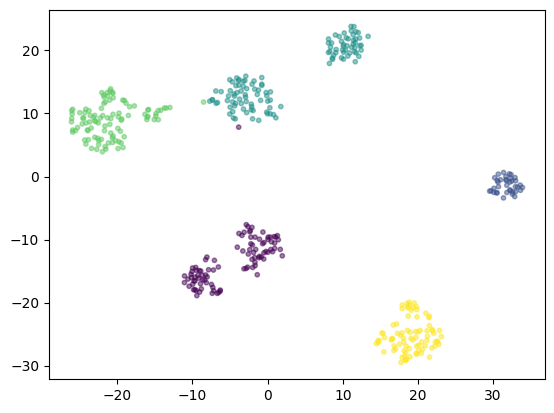

In [25]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.5 )


In [26]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=3402, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [27]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 5
    for label in range(5):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [28]:
int_to_label={
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [29]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    
print(predict(train_dataset[10]['anchor']))   
    
print(int_to_label[train_dataset[10]['label']])

test order dependency
test order dependency


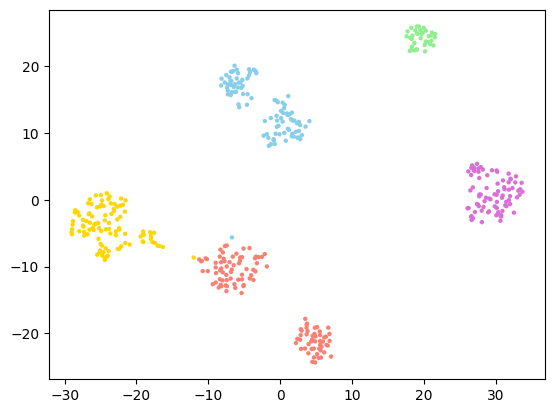

In [30]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# previous best result learing rate: 1e-5
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Scatter plot
for i, label in enumerate(labelsNums[:len(X_embedded)]):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
# legend_labels = list(shortened_labels.values())  # Use shortened labels for legend
# plt.legend(labels=legend_labels)

plt.show()


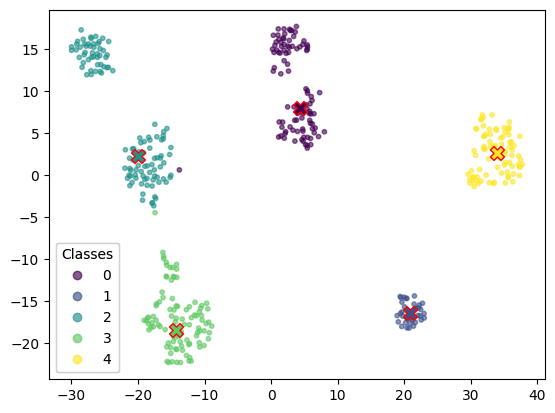

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [32]:
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# # Assuming 'X_embedded' is your t-SNE result and 'labelsNums' are your labels

# # Silhouette Score:
# # - Measures how similar an object is to its own cluster compared to other clusters.
# # - Range: -1 (incorrect clustering) to 1 (highly dense clustering). 
# #   A score close to 1 means that the clusters are well separated and clearly defined.
# silhouette_avg = silhouette_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Silhouette Score: {silhouette_avg}")

# # Davies-Bouldin Index:
# # - Evaluates the clustering quality by measuring the average 'similarity' between each cluster 
# #   and its most similar one. The similarity is based on a ratio of within-cluster distances to between-cluster distances.
# # - Range: 0 to +∞. Lower scores indicate better clustering quality.
# davies_bouldin = davies_bouldin_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Davies-Bouldin Index: {davies_bouldin}")

# # Calinski-Harabasz Index:
# # - Measures the cluster validity based on the ratio between the within-cluster dispersion and the between-cluster dispersion.
# # - Range: Higher values indicate better clustering quality, with no upper limit. Low values indicate clusters with high overlap.
# calinski_harabasz = calinski_harabasz_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Calinski-Harabasz Index: {calinski_harabasz}")


In [33]:
    from sklearn.metrics import f1_score

    int_to_label={
        0: 'async wait',
        1: 'unordered collections',
        2: 'concurrency',
        3: 'time',
        4: 'test order dependency'
    }
    count = 0

    # Assuming val_dataset is iterable and has 'anchor' and 'label' keys
    predicted_labels = []
    true_labels = []

    for item in val_dataset:
        count+=1
        input_vector = item['anchor']  # Your input vector for prediction
        predicted_label = predict(input_vector)  # Get predicted cluster/label
        predicted_labels.append(predicted_label)
        
        true_label = item['label']  # True label
        true_label = int_to_label[int(true_label)]
        true_labels.append(true_label)
        print(count, " ",predicted_label, " " ,true_label)
    # Convert predicted labels to the same format as true_labels if necessary
    # This might include converting cluster IDs to the label format, depending on how your `predict` function outputs the prediction

    # Note: Ensure that your predict function returns labels in a format that matches true_labels or adjust accordingly
    print("loop completed")
    # Calculate F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Adjust 'average' as necessary
    print(f"F1 Score: {f1}")


1   async wait   async wait
2   test order dependency   unordered collections
3   time   time
4   concurrency   concurrency
5   async wait   async wait
6   async wait   async wait
7   concurrency   concurrency


8   concurrency   concurrency
9   async wait   async wait
10   concurrency   concurrency
11   unordered collections   unordered collections
12   unordered collections   unordered collections
13   concurrency   concurrency
14   unordered collections   unordered collections
15   concurrency   concurrency
16   time   time
17   async wait   async wait
18   async wait   async wait
19   time   time
20   time   time
21   test order dependency   test order dependency
22   time   async wait
23   unordered collections   unordered collections
24   test order dependency   test order dependency
25   concurrency   concurrency
26   async wait   async wait
27   async wait   time
28   unordered collections   unordered collections
29   test order dependency   test order dependency
30   concurrency   async wait
31   time   time
32   concurrency   concurrency
33   time   time
34   async wait   async wait
35   unordered collections   unordered collections
36   async wait   async wait
37   concurrency   asy

                       precision    recall  f1-score   support

           async wait       0.70      0.70      0.70        27
          concurrency       0.72      0.78      0.75        27
test order dependency       0.80      0.80      0.80        20
                 time       0.76      0.76      0.76        21
unordered collections       0.83      0.71      0.77        14

             accuracy                           0.75       109
            macro avg       0.76      0.75      0.76       109
         weighted avg       0.75      0.75      0.75       109


 - Accuracy :  0.75
 - Precision :  0.75
 - Recall :  0.75
 - F1 score :  0.75
 - MCC :  0.69
 - AUC :  0.84


Perfomnaces by categories



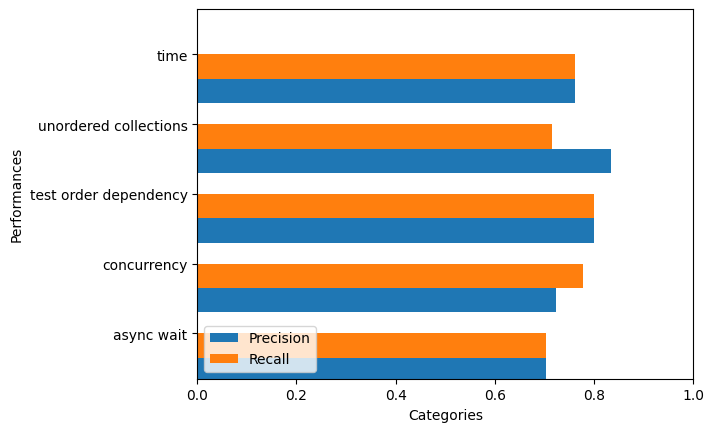



Confusion Matrix 


<AxesSubplot:>

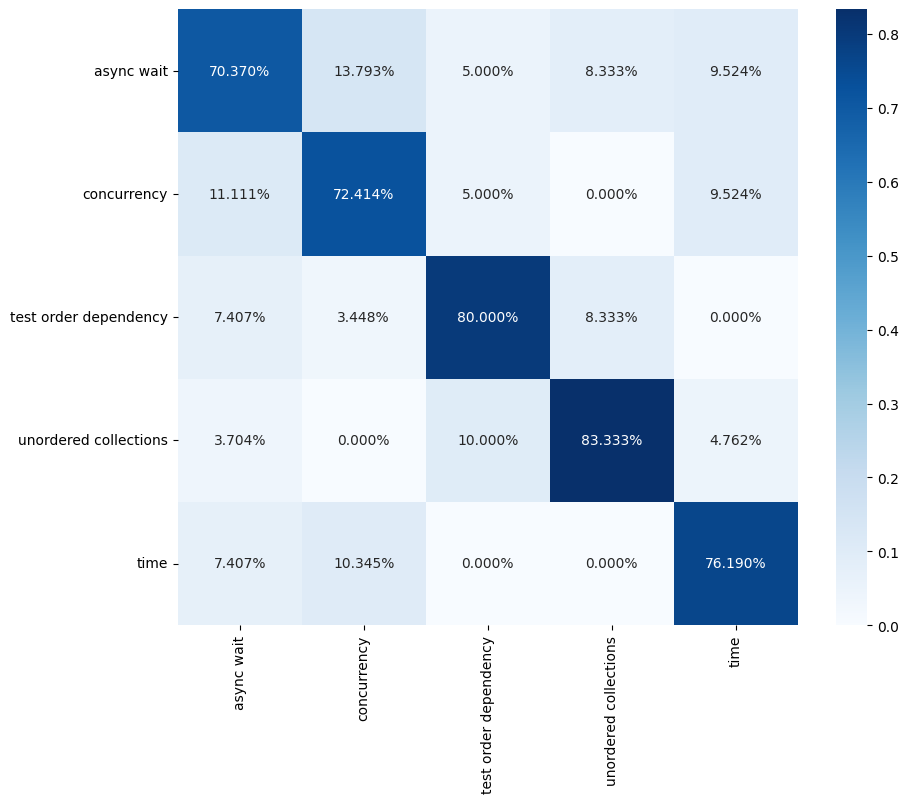

In [34]:
%matplotlib inline
warnings.filterwarnings("ignore")
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


predicted = predicted_labels
labels = true_labels
unique_labels = list ( set(labels ) )
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

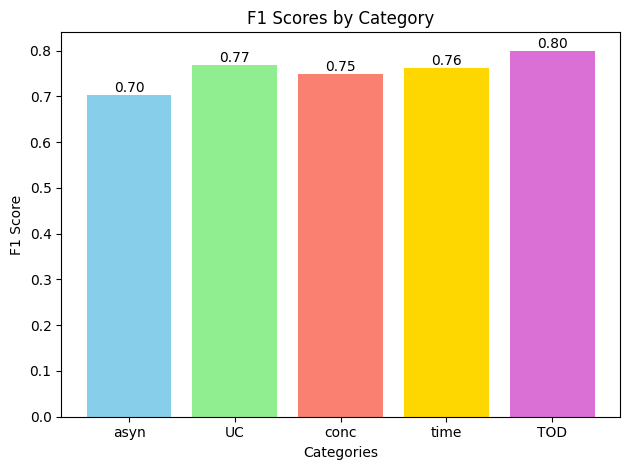

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
int_to_label = {
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}

# Shortened category names
shortened_labels = {
    'async wait': 'asyn',
    'unordered collections': 'UC',
    'concurrency': 'conc',
    'time': 'time',
    'test order dependency': 'TOD'
}

# Convert true and predicted labels back to integers for F1 score calculation
true_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in true_labels]
predicted_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in predicted_labels]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.values())
for category in categories:
    true_bin = [1 if label == category else 0 for label in true_labels]
    pred_bin = [1 if label == category else 0 for label in predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[category] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [36]:
# file_path = 'test_data_predictions.csv'

# # Load the compressed CSV file into a DataFrame
# df = pd.read_csv(file_path)

# # Extract the 'TrueLabel' and 'PredictedLabel' columns into separate variables
# labels_flaky = df['TrueLabel'].tolist()
# predicted_flaky = df['PredictedLabel'].tolist()

# print (classification_report(labels, predicted))

# print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels_flaky,  predicted_flaky) , 2))
# print(' - Precision : ' , np.round( metrics.precision_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - Recall : ' , np.round( metrics.recall_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - F1 score : ' , np.round( metrics.f1_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels_flaky,  predicted_flaky) , 2))
# print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels_flaky,  predicted_flaky),2) )

# print("\n\nPerfomnaces by categories\n")


# ind = np.arange(len(unique_labels)) 
# width = 0.35
# fig, ax = plt.subplots()
# precision = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[0]
# recall = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[1]
# ax.barh(ind - width/2, precision, width, label='Precision')
# ax.barh(ind + width/2, recall, width, label='Recall')
# ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
# ylim=[2*width - 1, len(ind)])
# plt.xlim(0,1)
# ax.legend(loc='upper right')
# ax.set_xlabel("Performances")
# ax.set_ylabel("Categories")
# plt.show()

# print("\n\nConfusion Matrix ")

# mat = confusion_matrix(labels_flaky,  predicted_flaky, labels=unique_labels)
# df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
# plt.figure(figsize = (10,8))
# sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

In [37]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics

# precision_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[0]
# recall_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[1]
# # And assuming 'unique_labels' is defined as before

# ind = np.arange(len(unique_labels))  # the x locations for the groups
# width = 0.2  # the width of the bars

# fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size as needed

# # Using a set of contrasting, darker colors
# colors = ['blue', 'green', 'red', 'orange']

# # Plotting Precision and Recall for Your Model
# rects1 = ax.bar(ind - width*1.5, precision_our_model, width, label='Our Precision', color=colors[0])
# rects2 = ax.bar(ind - width/2, recall_our_model, width, label='Our Recall', color=colors[1])

# # Plotting Precision and Recall for Flaky Model
# rects3 = ax.bar(ind + width/2, precision_flaky, width, label='FlakyCat Precision', color=colors[2])
# rects4 = ax.bar(ind + width*1.5, recall_flaky, width, label='FlakyCat Recall', color=colors[3])

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Class-wise Precision and Recall for Our Model vs. FlakyCat Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(unique_labels, rotation=45, ha="right")  # Rotate for better label visibility
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the figure

# # Optional: Adding scores above bars
# ax.bar_label(rects1, padding=3, fmt='%.2f')
# ax.bar_label(rects2, padding=3, fmt='%.2f')
# ax.bar_label(rects3, padding=3, fmt='%.2f')
# ax.bar_label(rects4, padding=3, fmt='%.2f')

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

# plt.show()


In [38]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming metrics have been calculated and stored in variables for both models.
# # Example metric variables: accuracy, precision, recall, f1_score, mcc, auc for the original model
# # And similarly named variables with a '_flaky' suffix for the comparison model.

# metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'AUC']
# your_model_metrics = [
#     np.round(metrics.accuracy_score(labels, predicted), 2),
#     np.round(metrics.precision_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.recall_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.f1_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels, predicted), 2),
#     np.round(multiclass_roc_auc_score(labels, predicted), 2)
# ]

# flaky_model_metrics = [
#     np.round(metrics.accuracy_score(labels_flaky, predicted_flaky), 2),
#     np.round(metrics.precision_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.recall_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.f1_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels_flaky, predicted_flaky), 2),
#     np.round(multiclass_roc_auc_score(labels_flaky, predicted_flaky), 2)
# ]

# x = np.arange(len(metrics_labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, your_model_metrics, width, label='Our Model')
# rects2 = ax.bar(x + width/2, flaky_model_metrics, width, label='FlakyCat Model')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Metrics Comparison between Our Model and FlakyCat Model')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def extract_projections(siamese_network, dataloader):
    projections = []
    labels = []
    for batch in dataloader:
        label = batch["label"]
        anchor = batch["anchor"]
        projection = siamese_network(anchor)
        
        projections.append(projection.cpu().detach().numpy())
        labels.append(label.numpy())
    projections = np.vstack(projections)
    labels = np.hstack(labels)
    return projections, labels

In [40]:
projections, labels = extract_projections(siamese_network, train_dataloader)
val_projections, val_labels = extract_projections(siamese_network, val_dataloader)

In [41]:
print(len(projections), len(train_dataloader))

436 55


In [42]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(projections, labels)

# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(projections, labels)

SVC(kernel='linear', random_state=42)

In [43]:
# Evaluate Random Forest Classifier
rf_predictions = rf_classifier.predict(val_projections)
rf_accuracy = accuracy_score(val_labels, rf_predictions)
rf_f1 = f1_score(val_labels, rf_predictions, average='weighted')
print(f"Random Forest Classifier Accuracy: {rf_accuracy}, F1: {rf_f1}")

# Evaluate SVM Classifier
svm_predictions = svm_classifier.predict(val_projections)
svm_accuracy = accuracy_score(val_labels, svm_predictions)
svm_f1 = f1_score(val_labels, svm_predictions, average='weighted')
print(f"SVM Classifier Accuracy: {svm_accuracy}, F1:{svm_f1}")

Random Forest Classifier Accuracy: 0.7614678899082569, F1: 0.762397560254195
SVM Classifier Accuracy: 0.7706422018348624, F1:0.7707943881192238
